(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import ActiveInference as AI

# Import basic math
import LinearAlgebra

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# Spin glass systems as collective active inference

Spin glass models, a generalization of the Ising model, have been used to 
understand the behavior of complex systems composed of interacting agents. 
Traditionally, the model takes a *global* perspective, where the system's 
Hamiltonian is written as a function of all of the spins in the system. The
most common form of the Hamiltonian is of the form
$$
E(\underline{x}) = -\sum_{(i,j)\in\mathcal{N}} J_{ij} x_i x_j - \sum_i h_i x_i,
\tag{1}
$$
where $x_i$ is the spin of agent $i$, $J_{ij}$ is the interaction strength
between spin $i$ and $j$, and $h_i$ is the external field acting on agent $i$.
The sum $\sum_{(i,j)\in\mathcal{N}}$ is taken over all pairs of interacting
spins where, for spin glass systems, not necessarily reflect nearest neighbors.
From this point of view, it is the state of the entire system $\underline{x}$
that determines the behavior of the system. This is a *global* perspective.

An alternative point of view is to consider the system as a collection of
individual *focal agents* (each spin as an agent) that are trying to infer the
state of its neighbors. This is a *local* perspective. In other words, rather
than thinking of a spin glass at a macroscopic level, the idea is to model each
individual spin as engaging in active inference of its environment, and having
the collective behavior emerge from this Bayesian inference problem.

## Generative model for a single spin

Since we take the modeling point of view that each spin is an agent, we allow
ourselves to talk about the spin's *observations* and *beliefs*. This is not to
say that the spin is given some sentience characteristics, but it is rather a
natural way to talk about agents engaging in Bayesian inference.

The spin's observations consist of a collection of binary states
$$
\underline{\sigma} = \left\{\sigma_1, \sigma_2, \ldots, \sigma_n\right\},
\;\; \sigma_i \in \{-1, 1\},
\tag{2}
$$
where
$$
\underline{\sigma} \subseteq \underline{x},
\tag{3}
$$
is a subset of the spins in the system that the focal agent can directly
observe.

In the spin's generative model, the state of the neighboring spins depends on a
single binary latent variable $z$. This *hidden spin state* can be interpreted
as a coarse-grained *average spin* of the neighboring spins. This generative
model can then be written as
$$
\pi(\underline{\sigma}, z) = \pi(\underline{\sigma} \mid z) \pi(z),
\tag{4}
$$
where $\pi(\cdot)$ is the probability distribution of the random variable.

Given the binary nature of both $z$ and $\underline{\sigma}$, we parametrize
the likelihood term $\pi(\underline{\sigma} \mid z)$ and the prior $\pi(z)$ as
Bernoulli distributions. For convenience, we express these Bernoulli 
distributions in an exponential rather than the usual form. The likelihood term
is then of the form
$$
\pi(\underline{\sigma} \mid z) = 
\prod_{i=1}^n \frac{
    \exp\left( \gamma \sigma_i z \right),
}{
    2 \cosh(\gamma z)
},
\tag{5}
$$
where $\gamma$ defines a single *sensory precision* parameter whose magnitude
captures how reliable the neighboring spin states indicate the value of the
hidden spin state $z$ in the spin's generative model. In other words, $\gamma$
parametrizes how much the spin trusts the state of neighbor spins as a readout
of the hidden spin state. A positive value of $\gamma$ indicates that spin
$\sigma_i$ and $z$ are positively correlated, while a negative value indicates
that they are negatively correlated. Furthermore, the product $\prod_{i=1}^n$
indicates that each spin's observation is independent of the others.

For the prior $\pi(z)$, we have another Bernoulli distribution of the form
$$
\pi(z) = \frac{
    \exp\left( \zeta z \right)
}{
    2 \cosh(\zeta)
},
\tag{6}
$$
where $\zeta$ acts as a *bias* in the spin's prior belief about the hidden spin
state. A positive value of $\zeta$ indicates a preference for $z=1$, while a
negative value indicates a preference for $z=-1$.

## Bayesian inference of hidden states

Given the generative model, we now consider the problem of the spin inferring
the state of the hidden spin $z$ given its observations $\underline{\sigma}$.
By Bayes' theorem, the posterior distribution of the hidden spin state is
$$
\pi(z \mid \underline{\sigma}) = \frac{
    \pi(\underline{\sigma} \mid z) \pi(z)
}{
    \sum_{z'} \pi(\underline{\sigma} \mid z') \pi(z')
}.
\tag{7}
$$
One can show that the posterior distribution is also a Bernoulli distribution
of the form
$$
\pi(z \mid \underline{\sigma}) = \frac{
    \exp\left( z (\zeta + \gamma \sum_i \sigma_i) \right)
}{
    2 \cosh(\zeta + \gamma \sum_i \sigma_i)
}.
\tag{8}
$$
However, notice that since each $\sigma_i$ is binary, the sum $\sum_i \sigma_i$
represents the difference between the number of spins in state $+1$ and the
the number of spins in state $-1$. Thus, we define
$$
\Delta \sigma = \sum_i \sigma_i,
\tag{9}
$$
allowing us to write the posterior distribution in the more compact form
$$
\pi(z \mid \underline{\sigma}) = \frac{
    \exp\left( z (\zeta + \gamma \Delta \sigma) \right)
}{
    2 \cosh(\zeta + \gamma \Delta \sigma)
}.
\tag{10}
$$

Let's define a function to compute this posterior distribution.

In [2]:
@doc raw"""
    spin_posterior(z, Δσ, γ, ζ)

Calculate the posterior probability of a spin state in a spin glass model under
active inference.

# Arguments
- `z`: The spin state. This should be either +1 (spin up) or -1 (spin down).
- `Δσ`: The difference in the total spin of the system when the spin state is
  flipped. This is a measure of the local magnetic field at the location of the
  spin.
- `γ`: The observation precision parameter, which determines the reliability of
  the spins' observations in determining the value of the hidden state.
- `ζ`: The precision of the prior beliefs about the spin states. 

# Returns
- The posterior probability of the spin state `z` given the local magnetic field
  `Δσ`, the precision of the coupling `γ`, and the precision of the prior
  beliefs `ζ`.
"""
function spin_posterior(z, Δσ, γ, ζ)
    return @. exp(z * (ζ + γ * Δσ)) / 2 / cosh(ζ + γ * Δσ)
end # spin_posterior

spin_posterior

Let's plot this posterior distribution for $z = +1$ for different values of
$\zeta$ at fized $\gamma$ and different values of $\gamma$ at fixed $\zeta$ as a
function of $\Delta \sigma$.

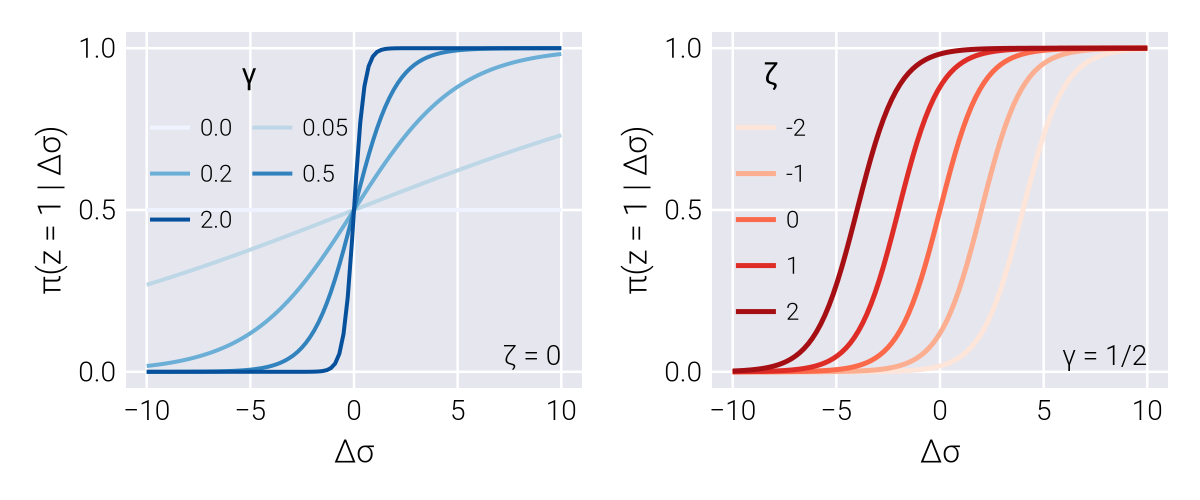

In [36]:
# Define value of z to evaluate posterior probability for
z = 1.0

# Define range of Δσ values to evaluate posterior probability for
Δσ = range(-10, 10, length=100)

# Define values of γ to evaluate
γ = [0.0, 0.05, 0.2, 0.5, 2.0]

# Define valuef of ζ to evaluate
ζ = [-2, -1, 0, 1, 2]

# Initialize figure
fig = Figure(size=(600, 250))

# Add axis for fixed ζ
axγ = Axis(
    fig[1, 1],
    xlabel="Δσ",
    ylabel="π(z = 1 | Δσ)",
)

# Loop through γ values
for (i, γi) in enumerate(γ)
    # Calculate posterior probability
    post = spin_posterior(z, Δσ, γi, 0)
    # Plot posterior probability
    lines!(
        axγ,
        Δσ,
        post,
        label="$γi",
        color=ColorSchemes.Blues_5.colors[i],
        linewidth=2,
    )
end

# Add legend
axislegend(
    axγ,
    "γ",
    position=:lt,
    labelsize=12,
    framevisible=false,
    nbanks=2,
    colgap=10
)

# Add text indicating fixed ζ
text!(10, 0, text="ζ = 0", align=(:right, :bottom))

# Add axis for fixed γ
axζ = Axis(
    fig[1, 2],
    xlabel="Δσ",
    ylabel="π(z = 1 | Δσ)",
)

# Loop through ζ values
for (i, ζi) in enumerate(ζ)
    # Calculate posterior probability
    post = spin_posterior(z, Δσ, 0.5, ζi)
    # Plot posterior probability
    lines!(
        axζ,
        Δσ,
        post,
        label="$ζi",
        color=ColorSchemes.Reds_5.colors[i],
        linewidth=2.5,
    )
end

# Add legend
axislegend(
    axζ,
    "ζ",
    position=:lt,
    labelsize=12,
    framevisible=false,
    nbanks=1,
)

# Add text indicating fixed γ
text!(10, 0, text="γ = 1/2", align=(:right, :bottom))


fig